In [1]:
import numpy as np
from Beta_optimization import alternating_beta_projection_log_nd
from KL_optimization import alternating_kl_projection_log_nd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def kl_divergence(p, empirical):
    """Compute the KL divergence between p and empirical distribution."""
    return np.sum(p * np.log((p) / (empirical)))

In [3]:
def sample_empirical(true_pi, num_samples):
    """
    Draws `num_samples` from the discrete distribution `true_pi`
    and returns an empirical probability tensor of the same shape,
    using your original flatten/unique/count logic.
    """
    # flatten the true distribution
    flat_probs = true_pi.flatten()
    
    # generation of empirical distribution from the true distribution
    picks = np.random.choice(len(flat_probs), size=num_samples, p=flat_probs)
    emp   = np.zeros_like(flat_probs)
    uniq, cnts = np.unique(picks, return_counts=True)
    emp[uniq] = cnts / num_samples
    
    # reshape back to the original tensor shape
    return emp.reshape(true_pi.shape)

Modifying the dataset

In [4]:
# Working directory
csv_path = "/Users/iiinov/IPF_zeros_generaliztion/toy_example/git_for_paper/indiv_rw_2021.csv"

# Load data
df = pd.read_csv(csv_path)

In [5]:
#Preparing data
# Age categorization
def categorize_age(age):
    if 15 <= age <= 23:
        return 1
    elif 24 <= age <= 64:
        return 2
    else:
        return -1

# Create the new column 'age_reduced'
df['age_reduced'] = df['age'].apply(categorize_age)

# Filter the original DataFrame based on the condition that age_reduced is 1, 2, and employment is not 4
filtered_df = df[(df['age_reduced'].isin([1, 2])) & (df['employment'] != 4)][['age_reduced', 'gender', 'employment']]

In [6]:
# Get the counts of each combination
joint_counts_reduced = (
    filtered_df
    .groupby(['age_reduced', 'gender', 'employment'])
    .size()
    .reset_index(name='count')
)

print(joint_counts_reduced)    

    age_reduced  gender  employment  count
0             1       1           1   1529
1             1       1           2    238
2             1       1           3    796
3             1       2           1   1524
4             1       2           2    214
5             1       2           3    871
6             2       1           1  14798
7             2       1           2   1245
8             2       1           3    156
9             2       2           1  13236
10            2       2           2   2527
11            2       2           3    135


In [7]:
# Create tensor object with counts
# Determine dimensions based on the max category values
I = filtered_df['age_reduced'].max()
J = filtered_df['gender'].max()
K = filtered_df['employment'].max()

# Create and populate the 3D tensor
tensor = np.zeros((I, J, K), dtype=int)
for _, row in joint_counts_reduced.iterrows():
    i, j, k = int(row['age_reduced']) - 1, int(row['gender']) - 1, int(row['employment']) - 1
    tensor[i, j, k] = row['count']

In [8]:
# Normalize tensor to get true data generating process
true_pdf = tensor / tensor.sum()
print(true_pdf)

[[[0.04102605 0.006386   0.02135823]
  [0.04089189 0.00574204 0.02337063]]

 [[0.39705922 0.03340578 0.00418578]
  [0.35514771 0.06780434 0.00362231]]]


In [9]:
# Calculate the marginals based on the normalized true_pdf
marginal_age = np.sum(true_pdf, axis=(1, 2))  # Sum over gender and employment 
marginal_gender = np.sum(true_pdf, axis=(0, 2))        # Sum over age and employment 
marginal_employment = np.sum(true_pdf, axis=(0, 1))     # Sum over age and gender 

Assign the parameters of simulation

In [10]:
target_trials = 1000
num_samples   = 200

# epsilon grid
eps_range = np.linspace(0.01, 0.001, num=10)

In [11]:
betas = [1.1, 1.2, 1.3]

# Containers for results
stats = {
    'avg_zero_counts':     [],                    # average number of zeros (imputations)
    'avg_zero_vals_kl':    [],                    # avg imputed values at zeros for KL
    'kl_divs_kl':          [],                    # avg KL divergence for KL
    'avg_zero_vals_beta':  {b: [] for b in betas},# avg imputed values at zeros for each β
    'kl_divs_beta':        {b: [] for b in betas},# avg KL divergence for each β
}

# Main grid search
for eps in eps_range:
    zeros_count_acc    = []
    zero_vals_kl       = []
    kl_vals_kl         = []
    zero_vals_beta     = {b: [] for b in betas}
    kl_vals_beta       = {b: [] for b in betas}

    for _ in range(target_trials):
        # generation of empirical distribution
        pi_hat = sample_empirical(true_pdf, num_samples)

        # locate zeros in the empirical tensor
        zero_idx = np.where(pi_hat == 0)
        zeros_count_acc.append(len(zero_idx[0]))

        # --- KL projection ---
        p_kl = alternating_kl_projection_log_nd(
            pi_hat,
            marginals=[marginal_age, marginal_gender, marginal_employment],
            num_iters=100,
            replace_zeros=True,
            epsilon=eps
        )
        # collect imputed values at zeros
        for idx in zip(*zero_idx):
            zero_vals_kl.append(p_kl[idx])
        # collect KL divergence
        kl_vals_kl.append(kl_divergence(p_kl, true_pdf))

        # --- Beta projections ---
        for b in betas:
            p_beta = alternating_beta_projection_log_nd(
                pi_hat,
                marginals=[marginal_age, marginal_gender, marginal_employment],
                beta=b,
                num_iters=1,
                full_cycles=50,
                replace_zeros=True,
                epsilon=eps
            )
            # collect imputed values at zeros
            for idx in zip(*zero_idx):
                zero_vals_beta[b].append(p_beta[idx])
            # collect KL divergence
            kl_vals_beta[b].append(kl_divergence(p_beta, true_pdf))

    # summarize for this ε
    stats['avg_zero_counts'].append(np.mean(zeros_count_acc))

    stats['avg_zero_vals_kl'].append(np.mean(zero_vals_kl))
    stats['kl_divs_kl']      .append(np.mean(kl_vals_kl))

    for b in betas:
        stats['avg_zero_vals_beta'][b].append(np.mean(zero_vals_beta[b]))
        stats['kl_divs_beta']      [b].append(np.mean(kl_vals_beta[b]))
        
    # print summary for this ε
    summary = (
        f"eps={eps:.4f} | "
        f"KL: avg00={stats['avg_zero_vals_kl'][-1]:.6f}, "
        f"KL-div={stats['kl_divs_kl'][-1]:.6f}"
    )
    for b in betas:
        summary += (
            f" || β={b}: "
            f"avg00={stats['avg_zero_vals_beta'][b][-1]:.6f}, "
            f"KL-div={stats['kl_divs_beta'][b][-1]:.6f}"
        )
    print(summary)


eps=0.0100 | KL: avg00=0.009157, KL-div=0.015213 || β=1.1: avg00=0.009083, KL-div=0.015365 || β=1.2: avg00=0.009001, KL-div=0.015693 || β=1.3: avg00=0.008912, KL-div=0.016263
eps=0.0090 | KL: avg00=0.008415, KL-div=0.015285 || β=1.1: avg00=0.008356, KL-div=0.015423 || β=1.2: avg00=0.008291, KL-div=0.015747 || β=1.3: avg00=0.008219, KL-div=0.016321
eps=0.0080 | KL: avg00=0.007688, KL-div=0.014714 || β=1.1: avg00=0.007649, KL-div=0.014896 || β=1.2: avg00=0.007603, KL-div=0.015267 || β=1.3: avg00=0.007550, KL-div=0.015893
eps=0.0070 | KL: avg00=0.006964, KL-div=0.013481 || β=1.1: avg00=0.006956, KL-div=0.013680 || β=1.2: avg00=0.006943, KL-div=0.014064 || β=1.3: avg00=0.006926, KL-div=0.014700
eps=0.0060 | KL: avg00=0.006132, KL-div=0.013496 || β=1.1: avg00=0.006144, KL-div=0.013727 || β=1.2: avg00=0.006155, KL-div=0.014153 || β=1.3: avg00=0.006163, KL-div=0.014844
eps=0.0050 | KL: avg00=0.005280, KL-div=0.013300 || β=1.1: avg00=0.005324, KL-div=0.013489 || β=1.2: avg00=0.005372, KL-div=0

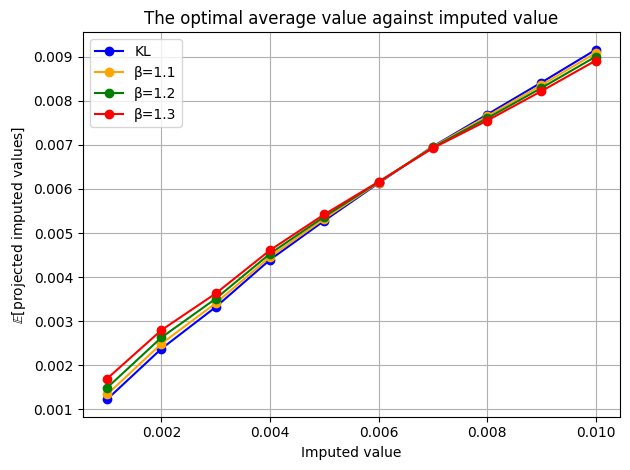

In [12]:
#Colors for graphs
colors = {
    'KL':    'blue',
    1.1:     'orange',
    1.2:     'green',
    1.3:     'red'
}

# KL curve
plt.plot(
    eps_range,
    stats['avg_zero_vals_kl'],
    marker='o',
    color=colors['KL'],
    label='KL'
)

# β curves
for b in betas:
    plt.plot(
        eps_range,
        stats['avg_zero_vals_beta'][b],
        marker='o',
        color=colors[b],
        label=rf'β={b}'
    )

plt.xlabel('Imputed value')
plt.ylabel(r'$\mathbb{E}[\text{projected imputed values}]$')
plt.title('The optimal average value against imputed value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('optimal_exp_vs_imp_real_data.png')
plt.show()



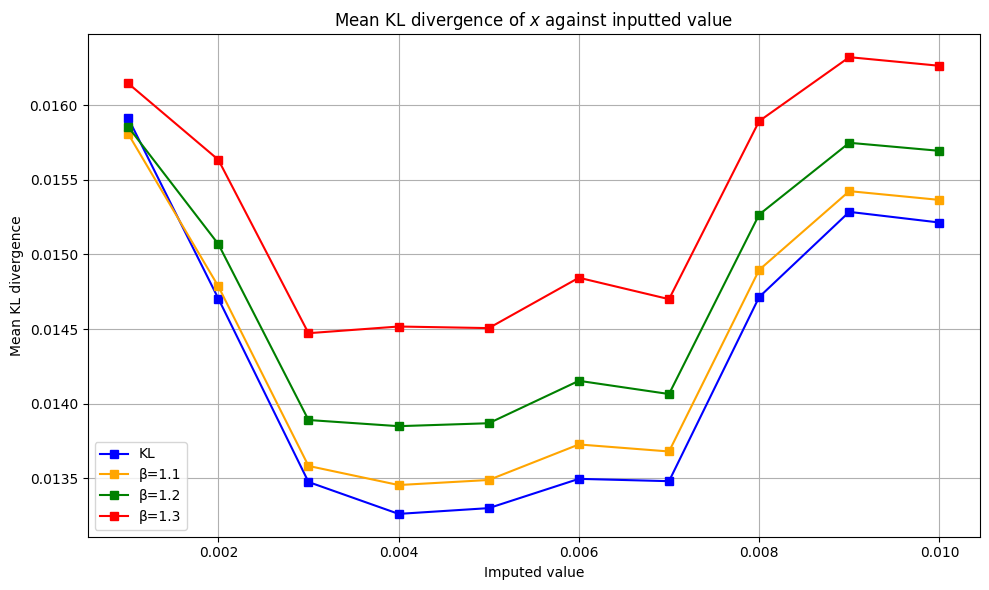

In [13]:
# --- Plot 2: KL divergence vs ε ---
plt.figure(figsize=(10,6))

# KL divergence curve
plt.plot(
    eps_range,
    stats['kl_divs_kl'],
    marker='s',
    color=colors['KL'],
    label='KL'
)

# β divergence curves
for b in betas:
    plt.plot(
        eps_range,
        stats['kl_divs_beta'][b],
        marker='s',
        color=colors[b],
        label=rf'β={b}'
    )

plt.xlabel('Imputed value')
plt.ylabel('Mean KL divergence')
plt.title(r'Mean KL divergence of $x$ against inputted value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mean_KL_vs_imp_real_data.png')
plt.show()
